This notebook exemplifies a simple market access estimation based on global datasets:

- **Global Friction Surface (Malaria Atlas Project)**  
see: https://developers.google.com/earth-engine/datasets/catalog/Oxford_MAP_friction_surface_2019


- **World Pop 1 km Population Grid**

### Required libraries

In [1]:
import sys, os
import pandas as pd
import geopandas as gpd
import numpy as np
import skimage.graph as graph
import rasterio as rio
from shapely.geometry import box, Point, Polygon
import matplotlib.pyplot as plt
from tqdm import tqdm

sys.path.append("/home/wb514197/Repos/GOST_Urban")
sys.path.append("/home/wb514197/Repos/INFRA_SAP")
sys.path.append('/home/wb514197/Repos/GOSTnets')

import src.UrbanRaster as urban
import infrasap.market_access as ma
import infrasap.rasterMisc as rMisc
from infrasap import aggregator
import GOSTnets.calculate_od_raw as calcOD

# Plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from rasterio.plot import plotting_extent
from mpl_toolkits.axes_grid1 import make_axes_locatable
import contextily as ctx

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Set up a data directory

In [3]:
iso3 = "BEN"
data_dir = "/home/wb514197/data/BEN"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

### 1. Clip global datasets to country extent

In [4]:
global_friction_surface = "/home/public/Data/GLOBAL/INFRA/FRICTION_2020/2020_motorized_friction_surface.geotiff"
global_population = "/home/public/Data/GLOBAL/Population/WorldPop_PPP_2020/ppp_2020_1km_Aggregated.tif"
inG = rio.open(global_friction_surface)
inP = rio.open(global_population)

# Read in country bounds
global_bounds = "/home/public/Data/GLOBAL/ADMIN/Admin0_Polys.shp"
admin1 = "/home/public/Data/GLOBAL/ADMIN/Admin1_Polys.shp"
admin2 = "/home/wb514197/data/PAK/pakistan_indicators.shp"

inB = gpd.read_file(global_bounds)
inB = inB.loc[inB['ISO3'] == iso3]
inB = inB.to_crs(inG.crs.to_string())

In [5]:
# Clip the travel raster to ISO3
out_travel_surface = os.path.join(data_dir, "TRAVEL_SURFACE.tif")
rMisc.clipRaster(inG, inB, out_travel_surface)

# Clip the population raster to ISO3
out_pop_surface = os.path.join(data_dir, "POP_2020_NEW.tif")
rMisc.clipRaster(inP, inB, out_pop_surface)

In [6]:
travel_surf = rio.open(out_travel_surface)
pop_surf = rio.open(out_pop_surface)

In [7]:
# Make sure that both rasters have the exact same resolution, crs, and number of pixels
out_pop_surface_std = os.path.join(data_dir, "POP_2020_NEW_STD.tif")
rMisc.standardizeInputRasters(pop_surf, travel_surf, os.path.join(data_dir, "POP_2020_NEW_STD.tif"), data_type="C")

### 2. Calculate urban extents

- Population Density > 300 people per sq. km
- Total population > 5,000 people

In [8]:
calc_urban = urban.urbanGriddedPop(out_pop_surface_std)
urban_extents = calc_urban.calculateUrban(densVal=300, totalPopThresh=5000, 
                          print_message=iso3, verbose=True)

10:03:52	BEN: Read in urban data
10:03:52	BEN: Creating Shape 0


In [9]:
urban_extents.geometry = urban_extents.representative_point()
urban_extents.set_index("ID", inplace=True)

### 3. Prepare origins (population grid)

Convert from raster format to csv/geopandas data frame

In [10]:
pop_surf = rio.open(out_pop_surface_std)
pop = pop_surf.read(1, masked=True)

In [11]:
indices = list(np.ndindex(pop.shape))

In [12]:
xys = [pop_surf.xy(ind[0], ind[1]) for ind in indices]

In [13]:
res_df = pd.DataFrame({
    'spatial_index': indices, 
    'xy': xys, 
    'pop': pop.flatten()
})

### 3. Calculate travel time

Original data expressed in units of minutes required to travel one metre.  
*Convert to minutes required to travel one pixel*


In [14]:
# create MCP object
inG_data = travel_surf.read(1) * 1000 #
# Correct no data values
inG_data[inG_data < 0] = 99999999
mcp = graph.MCP_Geometric(inG_data)

In [15]:
# for each destination get cost of travel for every origin
for idx, dest in tqdm(urban_extents.iterrows()):
    dest_gdf = gpd.GeoDataFrame([dest], geometry='geometry', crs='EPSG:4326')
    res = ma.calculate_travel_time(travel_surf, mcp, dest_gdf)[0]
    res_df.loc[:,idx] = res.flatten()

20it [00:02,  7.87it/s]


In [16]:
# remove values where pop is 0 or nan
res_df = res_df.loc[res_df['pop']!=0].copy()
res_df = res_df.loc[~(res_df['pop'].isna())].copy()

In [17]:
od_cities = np.array(res_df[urban_extents.index])

### 4. Calculate Market Access

In [18]:
access_cities = calcOD.calculate_gravity(od_cities, dWeight = urban_extents['Pop'])

In [19]:
access_cities.index = res_df.index

In [20]:
access_cities_results = res_df.join(access_cities).rename(columns = {
        'd_0.01': 'd_1',
        'd_0.005': 'd_2',
        'd_0.001' : 'd_3',
        'd_0.0007701635' : 'd_4',   # Market access halves every 15 mins
        'd_0.0003850818' : 'd_5',   # Market access halves every 30 mins
        'd_0.0001925409' : 'd_6',   # Market access halves every 60 mins
        'd_9.62704e-05' : 'd_7',   # Market access halves every 120 mins
        'd_3.85082e-05' : 'd_8',   # Market access halves every 300 mins
        'd_1e-05' : 'd_9'
    })

In [21]:
geoms = [Point(xy) for xy in access_cities_results.xy]

In [22]:
access_cities_results = gpd.GeoDataFrame(access_cities_results, geometry=geoms, crs=urban_extents.crs)

### 5. Save results in raster format

In [23]:
output_path = os.path.join(data_dir, "output")
if not os.path.exists(output_path):
    os.mkdir(output_path)

In [24]:
for d in range(3,10):
    print(f'writing {d}')
    aggregator.rasterize_gdf(access_cities_results, f'd_{d}', template=out_travel_surface, outFile=os.path.join(output_path,f"access_cities_d{d}.tif"))

writing 3
writing 4
writing 5
writing 6
writing 7
writing 8
writing 9


Convert travel time to hours and get minimum travel cost to nearest city

In [25]:
access_cities_results = access_cities_results.apply(lambda x: x/60 if x.name in urban_extents.index else x)

In [26]:
access_cities_results.loc[:, "tt_min"] = access_cities_results[urban_extents.index].min(axis=1)

In [27]:
aggregator.rasterize_gdf(access_cities_results, 'tt_min', out_travel_surface, os.path.join(output_path,f"cities_min_tt.tif"))

### 6. Map results

In [28]:
tt_min_ = rio.open(os.path.join(output_path,f"cities_min_tt.tif"))
tt_min = tt_min_.read(1)

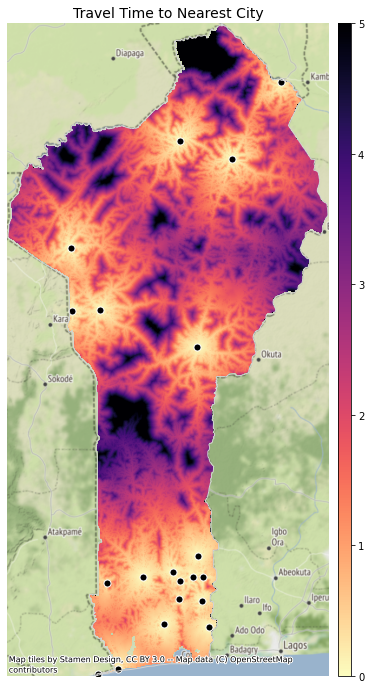

In [30]:
figsize = (12,12)
fig, ax = plt.subplots(1, 1,  figsize = figsize)
ax.set_title("Travel Time to Nearest City", fontsize=14)

plt.axis('off')
ext = plotting_extent(travel_surf)

im = ax.imshow(tt_min, vmin=0, vmax=5, cmap='magma_r', extent=ext)

ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain, crs='EPSG:4326', zorder=-10)

urban_extents.plot(ax=ax, facecolor='black', edgecolor='white', markersize=50, alpha=1)
inB.plot(ax=ax, facecolor='none', edgecolor='lightgrey')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size="4%", pad=0.1)
cb = fig.colorbar(im, cax=cax, orientation='vertical')

plt.savefig(os.path.join(output_path, "Map of Travel Time.png"), dpi=300, bbox_inches='tight', facecolor='white')

In [31]:
ma_index_ = rio.open(os.path.join(output_path,f"access_cities_d3.tif"))
ma_index = ma_index_.read(1)

In [32]:
np.nanmin(ma_index)

0.0

In [33]:
np.nanmax(ma_index)

5840619.394327072

In [34]:
np.nanpercentile(ma_index.flatten(), 5)

2519853.649800649

In [35]:
np.nanpercentile(ma_index.flatten(), 95)

5315884.548247239

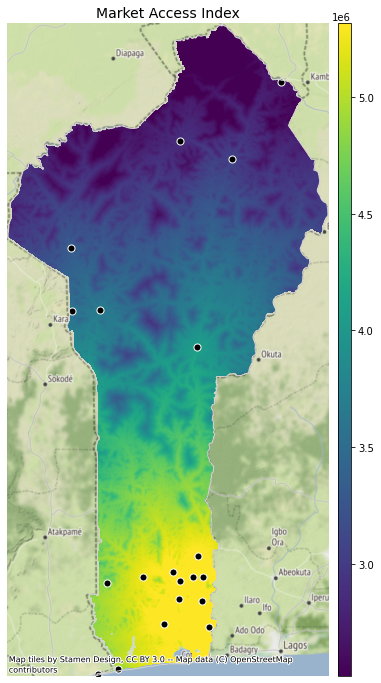

In [36]:
figsize = (12,12)
fig, ax = plt.subplots(1, 1,  figsize = figsize)
ax.set_title("Market Access Index", fontsize=14)

plt.axis('off')
ext = plotting_extent(travel_surf)

im = ax.imshow(ma_index, cmap='viridis', vmin=np.nanpercentile(ma_index.flatten(), 5), vmax=np.nanpercentile(ma_index.flatten(), 95), extent=ext)

ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain, crs='EPSG:4326', zorder=-10)

urban_extents.plot(ax=ax, facecolor='black', edgecolor='white', markersize=50, alpha=1)
inB.plot(ax=ax, facecolor='none', edgecolor='lightgrey')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size="4%", pad=0.1)
cb = fig.colorbar(im, cax=cax, orientation='vertical')

plt.savefig(os.path.join(output_path, "Map of Market Access.png"), dpi=300, bbox_inches='tight', facecolor='white')